# Isochrone Fitting

In [1]:
import urllib
import re
import pandas as pd
import numpy
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit as cf

def lin_func(x,m,c):
    y = m*x + c
    return y

#import data online from HUGS server
def read_data(targ):
    ins = "wfc3-uvis-acs-wfc"
    filt = "multi"
    exteng = "1"

    url = "https://archive.stsci.edu/hlsps/hugs/ngc"+targ+"/hlsp_hugs_hst_"+ins+"_ngc"+targ+"_"+filt+"_v1_catalog-meth"+exteng+".txt"
    file = urllib.request.urlopen(url)   

    ptr = 1
    hd = [] #header of the dataframe

    hd.append("Nan") #This is because there is a space in the beginning of each line in all data file.
    hd.append("X")  
    hd.append("Y")

# Make two files. One contains all data in single spaced form (f1) and other is the unedited file to take out headers(f2).
    with open(r"D:\IIT material\Krittika python project\NGC"+targ+" data.txt", 'w') as f1, open(r"D:\IIT material\Krittika python project\NGC"+targ+" header.txt", 'w') as f2:
        for line in file:
            line = line.decode("utf-8")
            f2.write(line)
            if ptr > 54: # This is where the real data starts.   
                f1.write(re.sub('[\t ]+',' ', line))  #remove extra spaces
            ptr += 1        

    with open(r"D:\IIT material\Krittika python project\NGC"+targ+" header.txt", 'r') as fr:
        lines = fr.readlines()

        for i in range(14, 50):
            hd.append(lines[i])



    file_path = r"D:\IIT material\Krittika python project\NGC"+targ+" data.txt"

    df = pd.read_csv(file_path, sep = ' ') #create dataframe

    df.columns = hd #put headers

    df.drop(['Nan'], inplace=True, axis=1) # 1st column just had empty space. So removed it.
    df.drop(df[df['# Col. 33: Membership Probability [-1.0: not available]\n'] < 90].index, inplace = True) #stars with more the 90 % probability
    df.drop(df[df['# Col.  3: F275W calibrated magnitude\n'] < 0].index, inplace = True) # positive magnitude
    df.drop(df[df['# Col.  9: F336W calibrated magnitude\n'] < 0].index, inplace = True)
    df.drop(df[df['# Col. 15: F438W calibrated magnitude\n'] < 0].index, inplace = True)
    df.drop(df[df['# Col. 27: F814W calibrated magnitude\n'] < 0].index, inplace = True)
    df.drop(df[df['# Col. 21: F606W calibrated magnitude\n'] < 0].index, inplace = True)
    df['Color index'] = df['# Col.  9: F336W calibrated magnitude\n'] - df['# Col. 21: F606W calibrated magnitude\n']
    return df

In [18]:
#Find the distance of the cluster from web manually

ddd = input("Distance of the cluster in kpc: ")

import astropy.coordinates as coord
import astropy.units as u

distance = float(ddd) * u.kpc
distmod = coord.Distance(distance).distmod.value 
distmod

Distance of the cluster in kpc: 9.6


14.91135616519784

The following file contains the data of a isochrone generated online from PARSEC isochrones. Here is a link http://stev.oapd.inaf.it/cgi-bin/cmd 

The data is a isochrone corresponding to age __10 Gyrs__ and extinction($A_v$) of __0.7__. The estimated age of the cluster is __10.2 Gyrs__ and this isochrone was the best fit as expected. 

In [51]:
k = 0
ptr = 1

with open(r"D:\IIT material\Krittika python project\output197093289419.dat.txt", 'r') as f, open(r"D:\IIT material\Krittika python project\output.txt", 'w') as ff:
    lines = f.readlines()
    
    for line in lines:
        if ptr > 14:
            ff.write(re.sub('[\t ]+',' ', line))
        ptr += 1
            
    l = lines[0].split
        
with open(r"D:\IIT material\Krittika python project\output.txt", 'r') as f:
    lines = f.readlines()
    
    i = 0
    for line in lines:
        if line[0] == "#":
            i += 1
        else:    
            with open("D:\IIT material\Krittika python project\isodata\iso"+str(i)+".txt", 'a') as fw:
                fw.write(line)
                
        k = i - 1
                
head = []

with open(r"D:\IIT material\Krittika python project\output.txt", 'r') as f:
    lines = f.readlines()
    
    l = lines[0].split()
    
    for i in range(len(l)):
        if l[i] != "#":
            head.append(l[i])

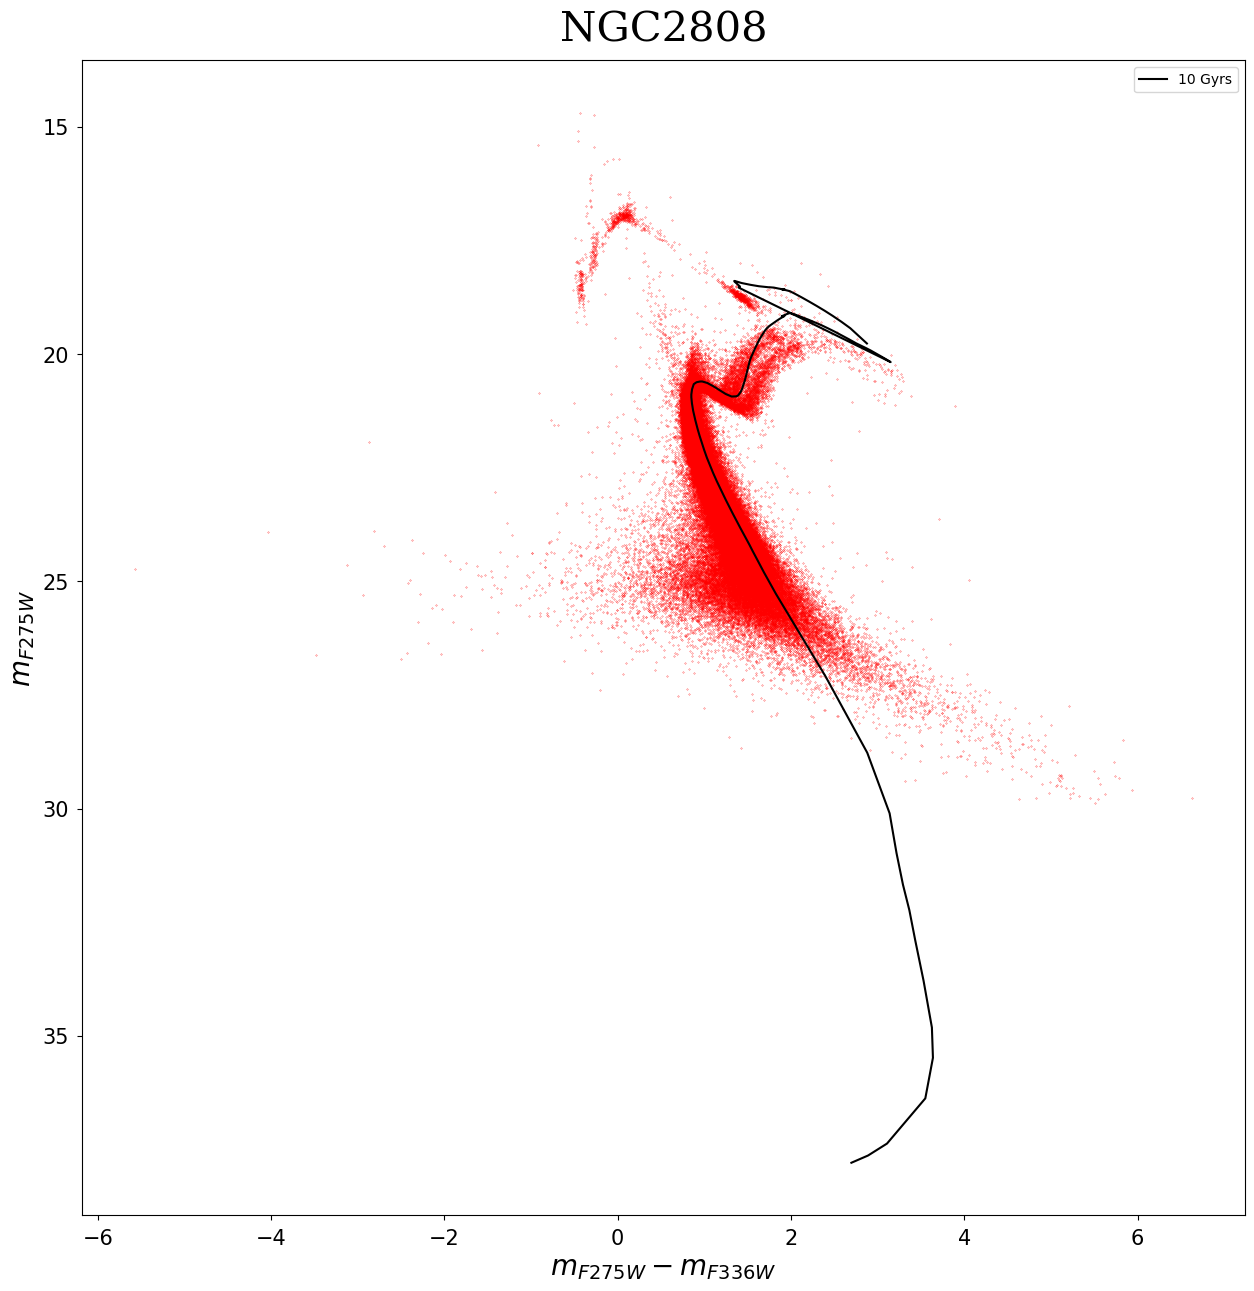

The age of the cluster is 10 Gyrs


In [56]:
def isochrone(i):
    d = pd.read_csv(r"D:\IIT material\Krittika python project\isodata\iso"+str(i)+".txt", sep = ' ')
    
    d.columns = head
    
    d.drop(d[(d['pmode'] >= 0) & (d['pmode'] < 3)].index, inplace = True)    
    d.index = pd.RangeIndex(len(d.index))
    d.index = range(len(d.index))
    
    col = d['F275Wmag'] - d['F336Wmag']
    magn = d['F275Wmag'] + distmod
    
    return col, magn
    
def col_mag(targ):
    
    df = read_data(targ)
    font = {'family': 'serif',
            'color':  'black',
            'weight': 'ultralight',
            'size': 20,
            }
      
    x1 = df['# Col.  3: F275W calibrated magnitude\n'] - df['# Col.  9: F336W calibrated magnitude\n']
    y1 = df['# Col.  3: F275W calibrated magnitude\n']
    
    xmin = x1.min()
    xmax = x1.max()
    ymin = y1.min()
    ymax = y1.max()
    
    plt.figure(figsize = (15, 15))
    
    col, mag = isochrone(1)
    col = col.drop(col.index[len(col)-1])
    mag = mag.drop(mag.index[len(mag)-1])
        
    plt.scatter(x1, y1, s = 0.05, color = 'red')
    plt.plot(col, mag, label = "10 Gyrs", color = 'black')
    plt.gca().invert_yaxis()
    plt.title("NGC"+targ, fontsize = 30, y = 1.01, fontdict = font)
    plt.xlabel(r'$m_{F275W} - m_{F336W}$', fontsize = 20, fontdict = font)
    plt.ylabel(r'$m_{F275W}$', fontsize = 20, fontdict = font)
    plt.tick_params(labelsize=15, pad = 6)
    plt.xlim = (xmin, xmax)
    plt.ylim = (ymin, ymax)
    plt.legend()
    plt.show()

    
col_mag("2808")